# Práctica 4:

##Resolución numérica de la distribución de temperaturas en una aleta

Grupo:

Nombre y apellidos 1:

Nombre y apellidos 2:

----------------------------


## Introducción

En esta práctica se va a utilizar el método de las diferencias finitas estudiado en la Práctica 2 para resolver la distribución de temperaturas en una aleta de longitud $L$. La ecuación a resolver es la ecuación diferencial de una aleta:

$$
	\rho c A_c \frac{\partial T }{\partial t} =  k A_c	\frac{\partial ^2 T }{\partial x^2} - hp(T-T_{\infty})\,
$$

donde $A_c$  es la sección de la aleta, $k$ es la conductividad del material, $\rho$ su densidad y $c$ su calor específico. Consideraremos estos parámetros constantes. Por otro lado $p$ es el perímetro de la sección de la aleta y $h$ el coeficiente de convección con el aire.

Para resolver numéricamente esta ecuación mediante el método de las diferencias finitas la reescribimos de la siguiente manera:

$$
	 \frac{\partial T }{\partial t} = b	\frac{\partial ^2 T }{\partial x^2} - bm^2(T-T_{\infty})\,
$$

donde $m=\sqrt{\frac{hp}{kA_c}}$ y $b=k/(\rho c)$.

Las posibles condiciones de contorno son:

- Temperatura en la base: $T(0)=T_b$
- Flujo de calor en la base: $q(0)=q_L$
- Punta adiabática: $q(L)=0$
- Convección en la punta: $q(L)=h(T(L)-T_{\infty})$



## Parte 1: Configuración de la simulación

En el código siguiente se ha implementado el método de las diferencias finitas para la resolución de la ecuación anterior, incluyendo la posibilidad de configurar las condiciones de contorno indicadas arriba. Se pide lo siguiente:

**1.a)** Completa el código con los valores de las constantes del problema y otros parámetros necesarios para la simulación, utilizando los datos de la aleta del laboratorio (muchos de estos datos vienen en el enunciado de la Práctica 3). Escoge como condiciones de contorno i) flujo de calor en la base y ii) punta adiabática.


In [ ]:
import numpy as np              # Librería para cálculo numérico
import math                     # Librería para utilizar símbolos matemáticos como el número pi, que se escribe como math.pi
from scipy import special
import matplotlib.pyplot as plt # Librería para poder dibujar gráficas
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.interpolate import Rbf

La longitud de la aleta es: 0.33 m
El parámetro m es: 9.128709291752768 m^-1
La difusividad térmica es: 1.4822134387351778e-05
El numero de nodos espaciales es: 20
El numero de pasos temporales es: 1965
El paso de tiempo es es: 2.035213296398892
El tiempo final es: 3997.1589141274235

Las posiciones de los termopares son (en m):
[0.018 0.048 0.078 0.108 0.138 0.168 0.198 0.228 0.258 0.288]


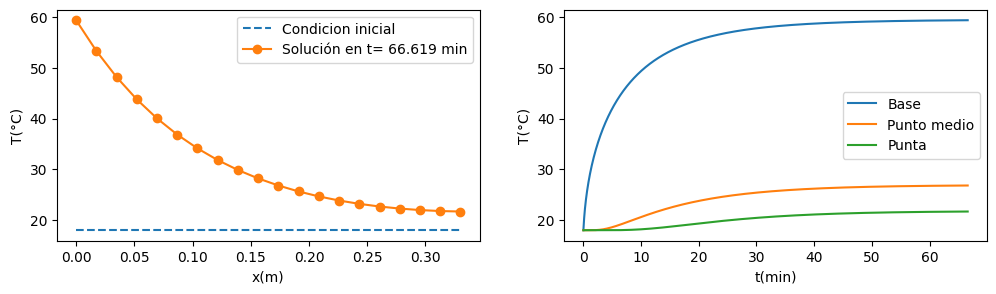

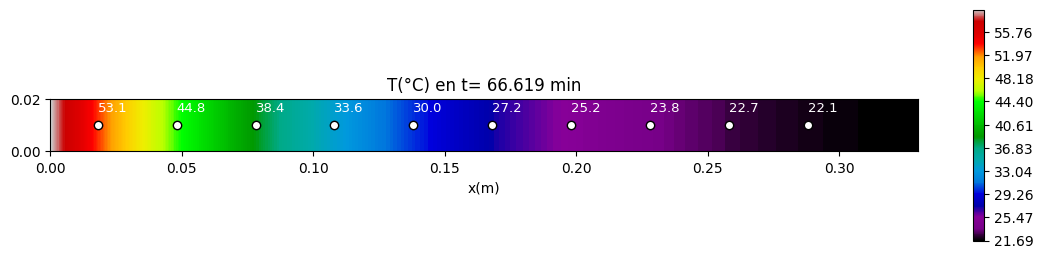

In [ ]:
#Primero definimos los parámetros del problema

L =   #longitud del dominio en metros
tf = 4000  #tiempo final que queremos simular en segundos
c =  #J/kgK
rho =  #kg/m^3
k = #W/(m·ºC)
h =  #W/(m^2·ºC)
w =  #m de anchura de la seccion
t =  #m de anchura de la sección
p = 2*w + 2*t
b  = k/(rho*c)   # valor de la difusividad térmica b=k/rho*c
Ac = w*t # area de la sección en m^2
m=np.sqrt(h*p/(k*Ac))

xpos=np.linspace(0,0.27,10)+0.018 # posiciones de los termopares

Tinf = #ºC
Tb =   #ºC

Power=   #Watt de potencia total generada en el calentador resistivo
f=0.7 #factor por perdidas en el calentador resistivo (no toda la potencia se transmite a la base de la aleta)
q_L=Power/Ac*f # Watt/m^2

#tipos de condiciones de contorno: fijar a 1 o 0 en cada caso
#base:
CCBTYPE = 0   # 1: temperatura en la base, 0: flujo de calor en la base
#punta:
CCPTYPE = 0   # 1: conveccion en la punta, 0: punta adiabática



#NO TOCAR DE AQUI HASTA EL FINAL

# Parametros discretización numérica diferencias finitas
N = 20   #numero de nodos espaciales en x
dx = L/(N-1)
sigma = 0.1 #sigma es un parametro que controla la estabilidad del metodo numérico
#después calculamos el paso de tiempo y el numero de pasos necesario
dt = sigma*dx**2/b #se calcula el paso de tiempo para la integración temporal
nt=int(tf/dt) # número de pasos de tiempo necesarios

print("La longitud de la aleta es:",L,"m")
print("El parámetro m es:",m,"m^-1")
print("La difusividad térmica es:",b)
print("El numero de nodos espaciales es:",N)
print("El numero de pasos temporales es:",nt)
print("El paso de tiempo es es:",dt)
print("El tiempo final es:",(nt-1)*dt)
print()

#inicializamos los arrays
x = np.zeros(N)
t = np.zeros(nt)
T = np.zeros((nt, N))

#damos valores a las posiciones espaciales
for i in range(N):
    x[i]=dx*i

#damos valores a los tiempos
for i in range(nt):
    t[i]=dt*i

#definimos la condición inicial
def initial_condition1(x):
    return np.piecewise(x, [x < 1, x >= 1], [Tinf, Tinf]) #con esto se define una condicion inicial a trozos, comprueba los valores

#imponemos la condición inicial en el tiempo "cero"
T[0,:] = initial_condition1(x)


#calculo de evolución de la temperatura en el tiempo
for n in range(0,nt-1): #bucle temporal desde 0 hasta nt-2
    for i in range(1,N-1): #bucle espacial entre 1 y N-2 (sin incluir primer y ultimo nodo)
        T[n + 1, i] = T[n,i] + b*dt/dx**2 * (T[n,i+1] + T[n,i-1] - 2*T[n,i]) - b*m*m*dt*(T[n,i]-Tinf)
        #condiciones de contorno en primer y ultimo nodo
        if CCBTYPE==1:
          T[n + 1, 0]=Tb
        else:
          T[n + 1, 0]=T[n, 0] + b*dt/dx**2 * (T[n,1]- T[n,0] + dx*q_L/k) - b*m*m*dt*(T[n,0]-Tinf)
        q_R=h*Ac*(T[n,N-1]-Tinf)*CCPTYPE
        T[n + 1, N-1]=T[n, N-1] + b*dt/dx**2 * (-dx*q_R/k - (T[n,N-1] - T[n,N-2])) - b*m*m*dt*(T[n,N-1]-Tinf)


# Representaciones graficas
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 3))
ax1.plot(x,T[0, :],'--',label='Condicion inicial')
ax1.plot(x,T[nt-1,:],'-o',label=f'Solución en t= {(nt-1)*dt/60:.3f} min')
ax1.set_xlabel("x(m)")
ax1.set_ylabel("T(°C)")
ax1.legend()

ax2.plot(t/60,T[:,0],'-',label='Base')
ax2.plot(t/60,T[:,int(N/2)],'-',label='Punto medio')
ax2.plot(t/60,T[:,N-1],'-',label='Punta')
ax2.set_xlabel("t(min)")
ax2.set_ylabel("T(°C)")
ax2.legend()

XX, YY = np.meshgrid(x, [0,.02])
T2D = np.zeros(np.shape(XX))
T2D[0,:] = T[nt-1,:]
T2D[1,:] = T[nt-1,:]

interpx = Rbf(XX, YY, T2D)
Tmeasures = interpx(xpos,np.zeros(len(xpos)))

print("Las posiciones de los termopares son (en m):")
print(xpos)

fig, ax = plt.subplots(figsize=(14, 3))
levels = np.linspace(np.min(T2D), np.max(T2D), 240)
CS = ax.contourf(XX, YY, T2D,levels=levels,cmap='nipy_spectral')
ax.set_title(f'T(°C) en t= {(nt-1)*dt/60:.3f} min')
ax.set_xlabel("x(m)")
ax.set_ylabel("")
plt.colorbar(CS)
ax.plot(xpos,np.ones(len(xpos))*0.01,'wo',markeredgecolor="k")
for i in range(len(xpos)):
  ax.text(xpos[i], 0.015, str(round(Tmeasures[i],1)), fontsize=9.5, color="white")
ax.set_aspect('equal', 'box')


## Análisis de la solución y comparación con medidas experimentales

**2.a)** Añade una gráfica $T$ frente a $x$ en la que se represente la distribución de temperatura calculada y medida en el laboratorio, en estado estacionario. Explica las diferencias

**2.b)** Añade una gráfica $T$ frente a $t$ en la que se represente la evolución temporal de la temperatura calculada y medida en el laboratorio en la sonda ST-0. Explica las diferencias.


In [ ]:
## haz copia-pega de la gráfica de arriba y de la Práctica 3 (datos experimentales y gráficas)

## Análisis de sensibilidad de la solución

**3.a)** Modifica la condición de contorno en la punta y explica lo que se observa.

....explicar aqui.....




Copia y pega el código de simulación del apartado 1.a) en la celda de código inferior y realiza lo siguiente:

**3.b)** En vez de imponer el flujo de calor a la entrada, fija como condición de contorno la temperatura en la base (puedes estimarla con la cámara térmica en el experimento). Representa la solución y explica las diferencias.

In [ ]:
# 3.b)